# Metodología de privatización

## Manipulación de datos

Primero se carga la base que nos suministro el ministerio de salud

In [7]:
import pandas as pd

archivo_csv = 'no_outliers.csv'

df = pd.read_csv(archivo_csv)

In [8]:
df.Valor_Neto.describe()

count    6.065900e+05
mean     3.041141e+05
std      6.233449e+05
min      1.000000e+00
25%      5.645500e+04
50%      1.452595e+05
75%      3.444485e+05
max      3.597299e+07
Name: Valor_Neto, dtype: float64

In [9]:
import torch

class Normalizer:
    @staticmethod
    def normalize_to_range(vector, min_range=-1, max_range=1):
        """
        Normalize a vector of numbers to a specified range using PyTorch.

        Parameters:
        vector (list or torch.Tensor): The vector of numbers to normalize.
        min_range (float): The minimum value of the range. Default is -1.
        max_range (float): The maximum value of the range. Default is 1.

        Returns:
        torch.Tensor: The normalized vector.
        """
        vector = torch.tensor(vector, dtype=torch.float32)
        min_val = torch.min(vector)
        max_val = torch.max(vector)

        normalized = (vector - min_val) / (max_val - min_val)

        normalized = normalized * (max_range - min_range) + min_range

        return normalized

In [10]:
import torch
import pandas as pd

class Normalizer:
    @staticmethod
    def normalize_to_range(vector, min_range=-1, max_range=1):
        """
        Normalize a vector of numbers to a specified range using PyTorch.

        Parameters:
        vector (list or torch.Tensor): The vector of numbers to normalize.
        min_range (float): The minimum value of the range. Default is -1.
        max_range (float): The maximum value of the range. Default is 1.

        Returns:
        torch.Tensor: The normalized vector.
        """
        vector = torch.tensor(vector, dtype=torch.float32)
        min_val = torch.min(vector)
        max_val = torch.max(vector)

        # Normalize to [0, 1]
        normalized = (vector - min_val) / (max_val - min_val)

        # Scale to [min_range, max_range]
        normalized = normalized * (max_range - min_range) + min_range

        return normalized

columns_to_normalize = ['DIAS_COMP', 'DIAS_ESTAN_Neto', 'Edad']

for column in columns_to_normalize:
    df[f'{column}'] = Normalizer.normalize_to_range(df[column].values)


In [11]:
import torch
import numpy as np
import pandas as pd

class AlgorithmDP:
    def __init__(self, df, epsilon, seed=None):
        self.df = df.copy()
        self.epsilon = epsilon
        self.privacy_preserving_instances = {}
        self.seed = seed
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)
    
    def add_privacy_instance(self, column, column_type):
        if column_type == 'categorical':
            self.privacy_preserving_instances[column] = PrivacyPreserving(self.df, column, self.epsilon, self.seed)
    
    def apply_privacy_to_column(self, column, method_name):
        if column in self.privacy_preserving_instances:
            instance = self.privacy_preserving_instances[column]
            if method_name in ["direct_encoding_privacy", "optimized_unary_encoding_privacy", "rappor_privacy"]:
                self.df[column] = instance.apply_privacy_method(method_name)
            else:
                raise ValueError(f"Invalid method name {method_name} provided for categorical column {column}.")
        else:
            if method_name == "duchi_solution":
                self.df[column] = AlgorithmDP.duchi_solution(self.df[column].values, self.epsilon, self.seed)
            elif method_name == "piecewise_mechanism":
                self.df[column] = AlgorithmDP.piecewise_mechanism(self.df[column].values, self.epsilon, self.seed)
            else:
                raise ValueError(f"Invalid method name {method_name} provided for numerical column {column}.")
        return self.df

    @staticmethod
    def duchi_solution(t_i_vector, epsilon, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        t_i_tensor = torch.tensor(t_i_vector, dtype=torch.float32)
        t_i_tensor = torch.clamp(t_i_tensor, -1, 1)
        e_epsilon = torch.exp(torch.tensor(epsilon, dtype=torch.float32))
        prob = (e_epsilon - 1) / (2 * e_epsilon + 2) * t_i_tensor + 0.5
        u = torch.bernoulli(prob.clone().detach())
        t_i_star = torch.where(u == 1, 
                               (e_epsilon + 1) / (e_epsilon - 1),
                               (1 - e_epsilon) / (e_epsilon + 1))
        return t_i_star.numpy()

    @staticmethod
    def piecewise_mechanism(t_i_vector, epsilon, seed=None):
        if seed is not None:
            torch.manual_seed(seed)
        t_i_tensor = torch.tensor(t_i_vector, dtype=torch.float32)
        t_i_tensor = torch.clamp(t_i_tensor, -1, 1)
        C = (torch.exp(torch.tensor(epsilon / 2)) + 1) / (torch.exp(torch.tensor(epsilon / 2)) - 1)
        def l(t_i): return (C + 1) / 2 * t_i - (C - 1) / 2
        def r(t_i): return l(t_i) + C - 1
        x = torch.rand(t_i_tensor.shape)
        threshold = torch.exp(torch.tensor(epsilon / 2)) / (torch.exp(torch.tensor(epsilon / 2)) + 1)
        t_i_star = torch.empty(t_i_tensor.shape, dtype=torch.float32)
        for i in range(t_i_tensor.shape[0]):
            l_val, r_val = l(t_i_tensor[i]), r(t_i_tensor[i])
            if x[i] < threshold:
                if l_val >= r_val: r_val = l_val + 1e-5
                t_i_star[i] = torch.distributions.Uniform(l_val, r_val).sample()
            else:
                if torch.rand(1) < 0.5:
                    if -C >= l_val: l_val = -C + 1e-5
                    t_i_star[i] = torch.distributions.Uniform(-C, l_val).sample()
                else:
                    if r_val >= C: r_val = C - 1e-5
                    t_i_star[i] = torch.distributions.Uniform(r_val, C).sample()
        return t_i_star.numpy()

class PrivacyPreserving:
    def __init__(self, df, column, epsilon, seed=None):
        self.df = df.copy()
        self.column = column
        self.epsilon = epsilon
        self.categories = df[column].unique()
        self.category_to_index = {category: i for i, category in enumerate(self.categories)}
        self.index_to_category = {i: category for i, category in enumerate(self.categories)}
        self.d = len(self.categories)
        self.seed = seed
        if seed is not None:
            np.random.seed(seed)
    
    def apply_privacy_method(self, method_name):
        if method_name == "direct_encoding_privacy":
            return self.direct_encoding_privacy()[self.column]
        elif method_name == "optimized_unary_encoding_privacy":
            return self.optimized_unary_encoding_privacy()[self.column]
        elif method_name == "rappor_privacy":
            return self.rappor_privacy()[self.column]
        else:
            raise ValueError(f"Invalid privacy method name: {method_name}")

    def direct_encoding_privacy(self):
        def direct_encoding(value, d, epsilon):
            p = np.exp(epsilon) / (np.exp(epsilon) + d - 1)
            q = 1 / (np.exp(epsilon) + d - 1)
            
            probabilities = np.full(d, q)
            probabilities[self.category_to_index[value]] = p
            privatized_index = np.random.choice(d, p=probabilities)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: direct_encoding(x, self.d, self.epsilon))
        return df_priv
    
    def optimized_unary_encoding_privacy(self):
        def optimized_unary_encoding(value, d, epsilon):
            p = 0.5
            q = 1 / (np.exp(epsilon) + 1)
            
            binary_vector = np.zeros(d)
            binary_vector[self.category_to_index[value]] = 1
            
            perturbed_vector = np.zeros(d)
            for i in range(d):
                if binary_vector[i] == 1:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[p, 1 - p])
                else:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[q, 1 - q])
            
            indices_positivos = np.where(perturbed_vector == 1)[0]
            if len(indices_positivos) == 0:
                indices_positivos = [self.category_to_index[value]]
            
            privatized_index = np.random.choice(indices_positivos)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: optimized_unary_encoding(x, self.d, self.epsilon))
        return df_priv
    
    def rappor_privacy(self):
        def rappor_encode(value, d, f=0.5):
            binary_vector = np.zeros(d)
            binary_vector[self.category_to_index[value]] = 1
            
            perturbed_vector = np.zeros(d)
            for i in range(d):
                if binary_vector[i] == 1:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[1 - f, f])
                else:
                    perturbed_vector[i] = np.random.choice([1, 0], p=[f, 1 - f])
            
            indices_positivos = np.where(perturbed_vector == 1)[0]
            if len(indices_positivos) == 0:
                indices_positivos = [self.category_to_index[value]]
            
            privatized_index = np.random.choice(indices_positivos)
            return self.index_to_category[privatized_index]
        
        df_priv = self.df.copy()
        df_priv[self.column] = df_priv[self.column].apply(lambda x: rappor_encode(x, self.d))
        return df_priv


In [12]:
epsilon = 1.0 
categorical_columns = ['SEXO', 'Grupo_Edad']  
numerical_columns = ['Valor_Neto']  
seed = 42  

dp_algorithm = AlgorithmDP(df, epsilon, seed)

for col in categorical_columns:
    dp_algorithm.add_privacy_instance(col, 'categorical')

privatized_df = dp_algorithm.apply_privacy_to_column('SEXO', 'direct_encoding_privacy')
privatized_df = dp_algorithm.apply_privacy_to_column('Grupo_Edad', 'direct_encoding_privacy')
privatized_df = dp_algorithm.apply_privacy_to_column('Valor_Neto', 'duchi_solution')


In [13]:
import pandas as pd

def compare_distribution(original_df, privatized_df, column):
    """
    Compara la distribución de una variable categórica entre un DataFrame original y uno privatizado.

    Parameters:
    original_df (pd.DataFrame): El DataFrame original sin privatización.
    privatized_df (pd.DataFrame): El DataFrame privatizado.
    column (str): El nombre de la columna categórica a comparar.

    Returns:
    pd.DataFrame: Un DataFrame que muestra la comparación de distribuciones en valor absoluto y porcentaje.
    """
    original_counts = original_df[column].value_counts().sort_index()
    original_percentage = original_counts / original_counts.sum() * 100

    privatized_counts = privatized_df[column].value_counts().sort_index()
    privatized_percentage = privatized_counts / privatized_counts.sum() * 100

    comparison_df = pd.DataFrame({
        'Original Count': original_counts,
        'Original %': original_percentage,
        'Privatized Count': privatized_counts,
        'Privatized %': privatized_percentage
    })

    comparison_df = comparison_df.fillna(0)

    comparison_df['Original %'] = comparison_df['Original %'].round(2)
    comparison_df['Privatized %'] = comparison_df['Privatized %'].round(2)
    
    return comparison_df



In [14]:
comparison_df = compare_distribution(df, privatized_df, 'SEXO')
print(comparison_df)

      Original Count  Original %  Privatized Count  Privatized %
SEXO                                                            
F             338770       55.85            319458         52.66
M             267820       44.15            287132         47.34


In [15]:
privatized_df = dp_algorithm.apply_privacy_to_column('Grupo_Edad', 'direct_encoding_privacy')
comparison_df = compare_distribution(df, privatized_df, 'Grupo_Edad')
print(comparison_df)

            Original Count  Original %  Privatized Count  Privatized %
Grupo_Edad                                                            
1                     7046        1.16             44951          7.41
2                    39463        6.51             49584          8.17
3                    83190       13.71             54970          9.06
4                    34440        5.68             48620          8.02
5                   265372       43.75             76900         12.68
6                    41362        6.82             49403          8.14
7                    35146        5.79             48726          8.03
8                    28051        4.62             47892          7.90
9                    22343        3.68             46768          7.71
10                   16477        2.72             46275          7.63
11                   13187        2.17             45809          7.55
12                   20513        3.38             46692          7.70


In [16]:
import pandas as pd
import numpy as np

def compare_distribution(df_original, df_priv, column):
    original_count = df_original[column].value_counts().sort_index()
    privatized_count = df_priv[column].value_counts().sort_index()
    
    original_pct = (original_count / original_count.sum()) * 100
    privatized_pct = (privatized_count / privatized_count.sum()) * 100
    
    comparison_df = pd.DataFrame({
        'Grupo_Edad': original_count.index,
        'Original Count': original_count.values,
        'Original (%)': original_pct.values,
        'Privatized (%)': privatized_pct.values
    }).fillna(0)
    
    return comparison_df

epsilon_values = [0.1, 0.5, 1.0, 2.0, 4.0, 6.0]

consolidated_results = pd.DataFrame()

for epsilon in epsilon_values:
    dp_algorithm = AlgorithmDP(df, epsilon, seed)
    dp_algorithm.add_privacy_instance('Grupo_Edad', 'categorical')
    privatized_df = dp_algorithm.apply_privacy_to_column('Grupo_Edad', 'direct_encoding_privacy')
    
    comparison_df = compare_distribution(df, privatized_df, 'Grupo_Edad')
    comparison_df = comparison_df[['Grupo_Edad', 'Privatized (%)']]
    comparison_df = comparison_df.rename(columns={'Privatized (%)': f'Privatized (%) (Epsilon={epsilon})'})
    
    if consolidated_results.empty:
        consolidated_results = compare_distribution(df, privatized_df, 'Grupo_Edad')[['Grupo_Edad', 'Original Count', 'Original (%)']]
        consolidated_results = pd.merge(consolidated_results, comparison_df, on='Grupo_Edad', how='outer')
    else:
        consolidated_results = pd.merge(consolidated_results, comparison_df, on='Grupo_Edad', how='outer')

cols = ['Grupo_Edad'] + [col for col in consolidated_results.columns if col != 'Grupo_Edad']
consolidated_results = consolidated_results[cols]




In [17]:
consolidated_results

,Grupo_Edad,Original Count,Original (%),Privatized (%) (Epsilon=0.1),Privatized (%) (Epsilon=0.5),Privatized (%) (Epsilon=1.0),Privatized (%) (Epsilon=2.0),Privatized (%) (Epsilon=4.0),Privatized (%) (Epsilon=6.0)
0,1,7046,1.161575,8.277420,7.976557,7.444732,5.850575,2.459981,1.369129
1,2,39463,6.505712,8.319458,8.267034,8.078933,7.743286,6.858339,6.561104
2,3,83190,13.714370,8.363969,8.600537,8.999324,10.169637,12.709903,13.553141
3,4,34440,5.677641,8.357210,8.254175,8.047940,7.404342,6.136270,5.748529
4,5,265372,43.748166,8.601527,10.076988,12.718475,20.628101,37.270479,42.712870
5,6,41362,6.818774,8.354407,8.265385,8.157075,7.806756,7.088973,6.853723
6,7,35146,5.794029,8.292257,8.154932,8.064920,7.445721,6.294861,5.880084
7,8,28051,4.624376,8.284179,8.157240,7.832473,7.052540,5.290888,4.739610
8,9,22343,3.683378,8.304291,8.089649,7.754496,6.752502,4.545739,3.814603
9,10,16477,2.716332,8.282365,8.049918,7.627557,6.391137,3.745034,2.882507


In [18]:

epsilon_values = [0.1, 0.5, 1.0, 2.0, 4.0, 6.0]

consolidated_results = pd.DataFrame()

for epsilon in epsilon_values:
    dp_algorithm = AlgorithmDP(df, epsilon, seed)
    dp_algorithm.add_privacy_instance('Grupo_Edad', 'categorical')
    privatized_df = dp_algorithm.apply_privacy_to_column('Grupo_Edad', 'optimized_unary_encoding_privacy')
    
    comparison_df = compare_distribution(df, privatized_df, 'Grupo_Edad')
    comparison_df = comparison_df[['Grupo_Edad', 'Privatized (%)']]
    comparison_df = comparison_df.rename(columns={'Privatized (%)': f'Privatized (%) (Epsilon={epsilon})'})
    
    if consolidated_results.empty:
        consolidated_results = compare_distribution(df, privatized_df, 'Grupo_Edad')[['Grupo_Edad', 'Original Count', 'Original (%)']]
        consolidated_results = pd.merge(consolidated_results, comparison_df, on='Grupo_Edad', how='outer')
    else:
        consolidated_results = pd.merge(consolidated_results, comparison_df, on='Grupo_Edad', how='outer')

cols = ['Grupo_Edad'] + [col for col in consolidated_results.columns if col != 'Grupo_Edad']
consolidated_results = consolidated_results[cols]

print("\nComparación consolidada de distribuciones con diferentes valores de epsilon:")
consolidated_results


Comparación consolidada de distribuciones con diferentes valores de epsilon:


,Grupo_Edad,Original Count,Original (%),Privatized (%) (Epsilon=0.1),Privatized (%) (Epsilon=0.5),Privatized (%) (Epsilon=1.0),Privatized (%) (Epsilon=2.0),Privatized (%) (Epsilon=4.0),Privatized (%) (Epsilon=6.0)
0,1,7046,1.161575,8.344516,8.168615,7.626074,5.866401,2.248801,1.321156
1,2,39463,6.505712,8.303302,8.221039,8.137292,7.712128,6.788440,6.547751
2,3,83190,13.714370,8.376993,8.542508,8.849965,10.211181,12.867176,13.581661
3,4,34440,5.677641,8.285992,8.245273,8.078768,7.451161,6.071482,5.736494
4,5,265372,43.748166,8.609275,9.500651,11.569594,20.458300,38.464696,42.962133
5,6,41362,6.818774,8.261758,8.263077,8.154437,7.848464,7.065563,6.846470
6,7,35146,5.794029,8.303632,8.252856,8.059150,7.440446,6.185727,5.844145
7,8,28051,4.624376,8.282200,8.276431,8.042170,7.096391,5.194448,4.718673
8,9,22343,3.683378,8.301159,8.172242,7.893635,6.726784,4.388961,3.784269
9,10,16477,2.716332,8.307259,8.075801,7.863796,6.349429,3.550504,2.844920


In [19]:
privatized_df = dp_algorithm.apply_privacy_to_column('Grupo_Edad', 'optimized_unary_encoding_privacy')
comparison_df = compare_distribution(df, privatized_df, 'Grupo_Edad')
print(comparison_df)

    Grupo_Edad  Original Count  Original (%)  Privatized (%)
0            1            7046      1.161575        1.318189
1            2           39463      6.505712        6.544783
2            3           83190     13.714370       13.600455
3            4           34440      5.677641        5.723306
4            5          265372     43.748166       42.959660
5            6           41362      6.818774        6.845645
6            7           35146      5.794029        5.851399
7            8           28051      4.624376        4.708617
8            9           22343      3.683378        3.796634
9           10           16477      2.716332        2.844920
10          11           13187      2.173956        2.313589
11          12           20513      3.381691        3.492804


In [20]:
epsilon_values = [0.1, 0.5, 1.0, 2.0, 4.0, 6.0]

consolidated_results = pd.DataFrame()

for epsilon in epsilon_values:
    dp_algorithm = AlgorithmDP(df, epsilon, seed)
    dp_algorithm.add_privacy_instance('Grupo_Edad', 'categorical')
    privatized_df = dp_algorithm.apply_privacy_to_column('Grupo_Edad', 'rappor_privacy')
    
    comparison_df = compare_distribution(df, privatized_df, 'Grupo_Edad')
    comparison_df = comparison_df[['Grupo_Edad', 'Privatized (%)']]
    comparison_df = comparison_df.rename(columns={'Privatized (%)': f'Privatized (%) (Epsilon={epsilon})'})
    
    if consolidated_results.empty:
        consolidated_results = compare_distribution(df, privatized_df, 'Grupo_Edad')[['Grupo_Edad', 'Original Count', 'Original (%)']]
        consolidated_results = pd.merge(consolidated_results, comparison_df, on='Grupo_Edad', how='outer')
    else:
        consolidated_results = pd.merge(consolidated_results, comparison_df, on='Grupo_Edad', how='outer')

cols = ['Grupo_Edad'] + [col for col in consolidated_results.columns if col != 'Grupo_Edad']
consolidated_results = consolidated_results[cols]

print("\nComparación consolidada de distribuciones con diferentes valores de epsilon:")
consolidated_results


Comparación consolidada de distribuciones con diferentes valores de epsilon:


,Grupo_Edad,Original Count,Original (%),Privatized (%) (Epsilon=0.1),Privatized (%) (Epsilon=0.5),Privatized (%) (Epsilon=1.0),Privatized (%) (Epsilon=2.0),Privatized (%) (Epsilon=4.0),Privatized (%) (Epsilon=6.0)
0,1,7046,1.161575,8.282695,8.282695,8.282695,8.282695,8.282695,8.282695
1,2,39463,6.505712,8.328360,8.328360,8.328360,8.328360,8.328360,8.328360
2,3,83190,13.714370,8.334295,8.334295,8.334295,8.334295,8.334295,8.334295
3,4,34440,5.677641,8.382928,8.382928,8.382928,8.382928,8.382928,8.382928
4,5,265372,43.748166,8.316161,8.316161,8.316161,8.316161,8.316161,8.316161
5,6,41362,6.818774,8.355561,8.355561,8.355561,8.355561,8.355561,8.355561
6,7,35146,5.794029,8.337922,8.337922,8.337922,8.337922,8.337922,8.337922
7,8,28051,4.624376,8.312534,8.312534,8.312534,8.312534,8.312534,8.312534
8,9,22343,3.683378,8.297862,8.297862,8.297862,8.297862,8.297862,8.297862
9,10,16477,2.716332,8.340724,8.340724,8.340724,8.340724,8.340724,8.340724


In [21]:
privatized_df = dp_algorithm.apply_privacy_to_column('Grupo_Edad', 'rappor_privacy')
comparison_df = compare_distribution(df, privatized_df, 'Grupo_Edad')
print(comparison_df)

    Grupo_Edad  Original Count  Original (%)  Privatized (%)
0            1            7046      1.161575        8.289454
1            2           39463      6.505712        8.327371
2            3           83190     13.714370        8.340889
3            4           34440      5.677641        8.335614
4            5          265372     43.748166        8.376168
5            6           41362      6.818774        8.314842
6            7           35146      5.794029        8.329679
7            8           28051      4.624376        8.319623
8            9           22343      3.683378        8.343197
9           10           16477      2.716332        8.367101
10          11           13187      2.173956        8.295719
11          12           20513      3.381691        8.360342


# Modelo

In [22]:
df.drop(columns='NUM_IDE', inplace=True)
df.drop(columns='FECHA_NACI', inplace=True)
df.drop(columns='id', inplace=True)
df.drop(columns='MUNI', inplace=True)

In [23]:
df.head()

,EPS,SEXO,DPTO,DIAS_COMP,V8,Valor_Neto,DIAS_ESTAN_Neto,Edad,SIDA_VIH,TUBERCULOSIS,...,RENAL_OTRA,RENAL_RENALDELARGADURACION,TRANSPLANTE,RENAL_INSUFICIENCIARENALOTRA,RENAL_INSUFICIENCIARENALCRONICA,ANOMALIASGENETICASYCONGENITAS,CANCER_TERAPIACANCER,Grupo_Edad,Zona,Valor_Neto_Log
0,EPS002,F,50,0.713604,B,39054.0,-1.000000,-0.803279,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,N,10.572701
1,EPS013,M,76,0.599045,C,312012.0,-0.998280,-0.622951,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,C,12.650797
2,EPS017,F,11,0.584725,B,14313.0,-1.000000,-0.754098,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,C,9.568923
3,EPS018,F,76,0.713604,B,319699.0,-0.999193,-0.934426,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2,C,12.675135
4,EPS016,M,8,0.713604,C,1084832.0,-0.984507,-0.131148,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,C,13.896936


In [25]:
import torch
import numpy as np
import pandas as pd

categorical_columns = ['EPS', 'SEXO', 'V8', 'Zona', 'Grupo_Edad','DPTO']
binary_columns = [col for col in df.columns if df[col].nunique() == 2 and col not in categorical_columns]
numerical_columns = ['DIAS_ESTAN_Neto', 'Edad']  

epsilon = 1.0
seed = 42  

df_original = df.copy()
df_priv = df.copy()


dp_algorithm = AlgorithmDP(df_priv, epsilon, seed)

for col in categorical_columns + binary_columns:
    dp_algorithm.add_privacy_instance(col, 'categorical')

for col in categorical_columns:
    df_priv = dp_algorithm.apply_privacy_to_column(col, 'direct_encoding_privacy')

for col in binary_columns:
    df_priv = dp_algorithm.apply_privacy_to_column(col, 'direct_encoding_privacy')

for col in numerical_columns:
    df_priv = dp_algorithm.apply_privacy_to_column(col, 'duchi_solution')

In [26]:
df_priv.to_csv('sin_oultiers_priv5.csv',index=False)

In [28]:
import pandas as pd

def compare_distributions(df_original, df_priv, categorical_columns, numerical_columns):
    comparison_results = {}
    
    for col in categorical_columns:
        print(f"\n--- Comparación de la variable categórica/binaria: {col} ---")
        
        original_counts = df_original[col].value_counts(normalize=True).sort_index() * 100
        priv_counts = df_priv[col].value_counts(normalize=True).sort_index() * 100
        
        comparison_df = pd.DataFrame({
            'Original (%)': original_counts,
            'Privatizado (%)': priv_counts
        }).fillna(0)
        
        print(comparison_df)
        comparison_results[col] = comparison_df
    
    for col in numerical_columns:
        print(f"\n--- Comparación de la variable numérica: {col} ---")
        
        original_stats = df_original[col].describe()
        priv_stats = df_priv[col].describe()
        
        comparison_df = pd.DataFrame({
            'Original': original_stats,
            'Privatizado': priv_stats
        })
        
        print(comparison_df)
        comparison_results[col] = comparison_df

    return comparison_results

categorical_columns = ['EPS', 'SEXO', 'V8', 'Zona', 'Grupo_Edad','DPTO']
binary_columns = [col for col in df_original.columns if df_original[col].nunique() == 2 and col not in categorical_columns]
categorical_columns += binary_columns

numerical_columns = [col for col in df_original.columns if col not in categorical_columns and col not in ['Valor_Neto', 'Valor_Neto_Log', 'NUM_IDE', 'FECHA_NACI', 'id']]

comparison_results = compare_distributions(df_original, df_priv, categorical_columns, numerical_columns)



--- Comparación de la variable categórica/binaria: EPS ---
        Original (%)  Privatizado (%)
EPS                                  
EPS001      1.472823         6.521538
EPS002      9.580771         7.386373
EPS003      3.932145         6.748545
EPS005      5.472725         6.975387
EPS008      4.210092         6.802618
EPS009      1.742363         6.608253
EPS010      8.196970         7.285481
EPS012      1.689774         6.536705
EPS013     22.560214         8.838095
EPS016     14.901663         7.970128
EPS017      7.651791         7.193491
EPS018      4.372970         6.865428
EPS023      3.220462         6.684251
EPS037     10.995236         7.583706

--- Comparación de la variable categórica/binaria: SEXO ---
      Original (%)  Privatizado (%)
SEXO                               
F        55.848267         52.68501
M        44.151733         47.31499

--- Comparación de la variable categórica/binaria: V8 ---
    Original (%)  Privatizado (%)
V8                               


In [29]:
df_priv.drop(columns='Valor_Neto', inplace=True)


Resultados de la regresión lineal (Lasso) comparando datos originales y privatizados:
     Métrica  Original  Privatizado
0   R2_train  0.094253     0.005748
1    R2_test  0.091168     0.005489
2  MAE_train  1.035920     1.092352
3   MAE_test  1.039228     1.094776


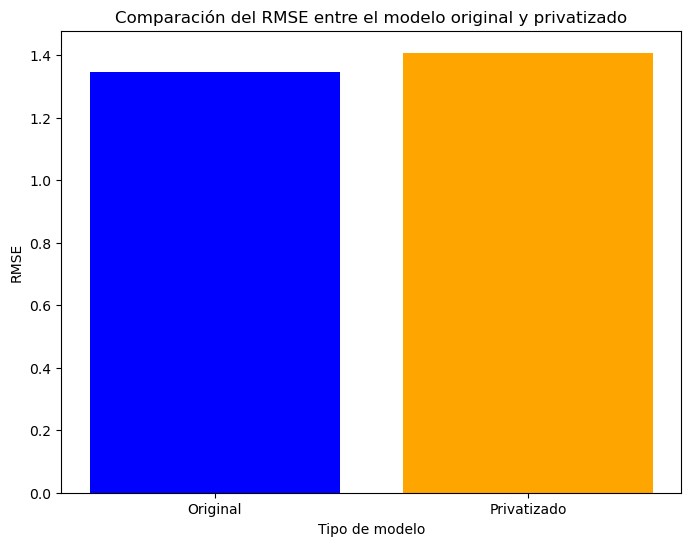

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

def perform_regression(df, target_column, categorical_columns, numerical_columns):
    X_categorical = pd.get_dummies(df[categorical_columns], drop_first=True)
    X_numerical = df[numerical_columns]
    
    X = pd.concat([X_categorical, X_numerical], axis=1)
    y = df[target_column]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = Lasso(alpha=0.1)
    model.fit(X_train, y_train)
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    metrics = {
        'R2_train': r2_score(y_train, y_train_pred),
        'R2_test': r2_score(y_test, y_test_pred),
        'MAE_train': mean_absolute_error(y_train, y_train_pred),
        'MAE_test': mean_absolute_error(y_test, y_test_pred),
        'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred))
    }
    
    return metrics

categorical_columns = ['EPS', 'SEXO', 'V8', 'Zona', 'Grupo_Edad','DPTO']
binary_columns = [col for col in df.columns if df[col].nunique() == 2 and col not in categorical_columns]
categorical_columns += binary_columns

numerical_columns = [col for col in df.columns if col not in categorical_columns and col not in ['Valor_Neto', 'Valor_Neto_Log', 'NUM_IDE', 'FECHA_NACI', 'id']]

metrics_original = perform_regression(df, target_column='Valor_Neto_Log', categorical_columns=categorical_columns, numerical_columns=numerical_columns)

metrics_priv = perform_regression(df_priv, target_column='Valor_Neto_Log', categorical_columns=categorical_columns, numerical_columns=numerical_columns)

results = pd.DataFrame({
    'Métrica': ['R2_train', 'R2_test', 'MAE_train', 'MAE_test'],
    'Original': [metrics_original['R2_train'], metrics_original['R2_test'], metrics_original['MAE_train'], metrics_original['MAE_test']],
    'Privatizado': [metrics_priv['R2_train'], metrics_priv['R2_test'], metrics_priv['MAE_train'], metrics_priv['MAE_test']]
})

print("\nResultados de la regresión lineal (Lasso) comparando datos originales y privatizados:")
print(results)

rmse_values = {
    'Original': metrics_original['RMSE_test'],
    'Privatizado': metrics_priv['RMSE_test']
}

plt.figure(figsize=(8, 6))
plt.bar(rmse_values.keys(), rmse_values.values(), color=['blue', 'orange'])
plt.title('Comparación del RMSE entre el modelo original y privatizado')
plt.xlabel('Tipo de modelo')
plt.ylabel('RMSE')
plt.show()


# Modelo de clasificación

Estadísticas descriptivas para 'Valor_Neto_Log':
count    606590.000000
mean         11.786431
std           1.410443
min           0.000000
25%          10.941199
50%          11.886277
75%          12.749700
max          17.398279
Name: Valor_Neto_Log, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


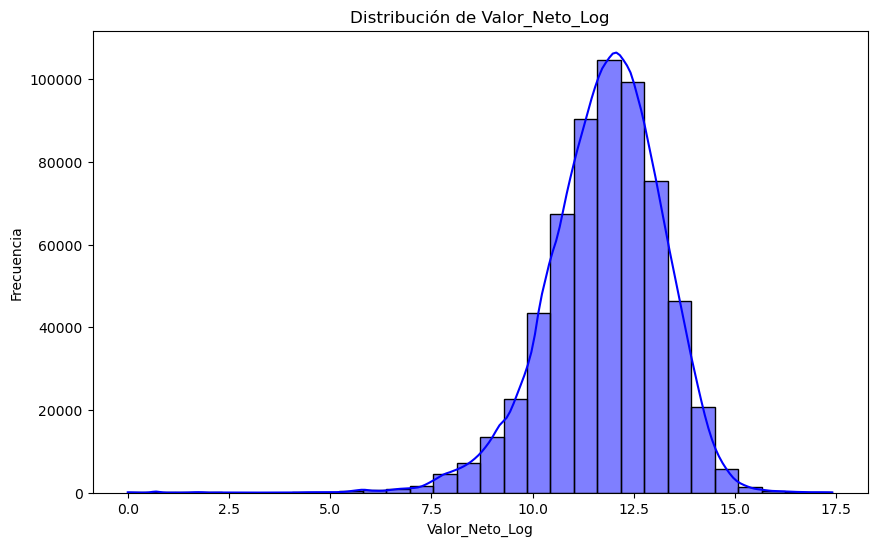

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

descriptive_stats = df_original['Valor_Neto_Log'].describe()

print("Estadísticas descriptivas para 'Valor_Neto_Log':")
print(descriptive_stats)

plt.figure(figsize=(10, 6))
sns.histplot(df_original['Valor_Neto_Log'], kde=True, bins=30, color='blue')
plt.title('Distribución de Valor_Neto_Log')
plt.xlabel('Valor_Neto_Log')
plt.ylabel('Frecuencia')
plt.show()


Estadísticas descriptivas para 'Valor_Neto':
count    6.065900e+05
mean     3.041141e+05
std      6.233449e+05
min      1.000000e+00
25%      5.645500e+04
50%      1.452595e+05
75%      3.444485e+05
max      3.597299e+07
Name: Valor_Neto, dtype: float64


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


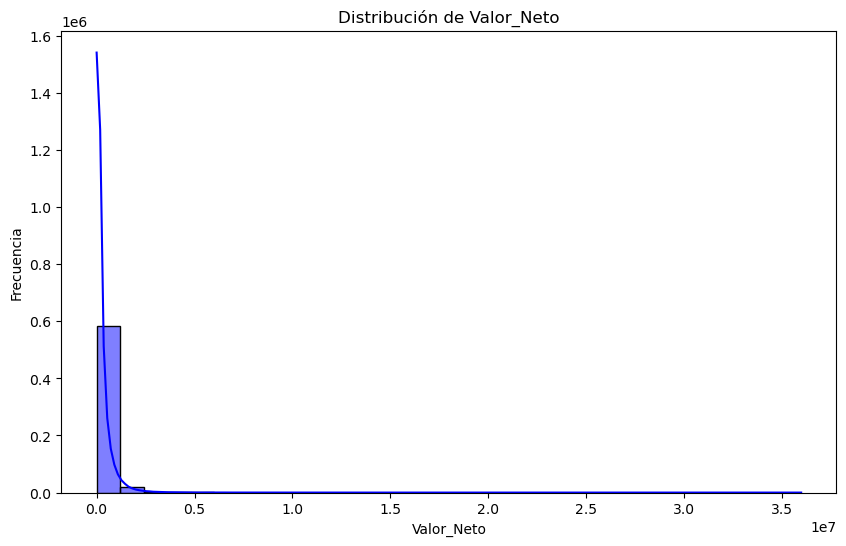

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

descriptive_stats = df_original['Valor_Neto'].describe()

print("Estadísticas descriptivas para 'Valor_Neto':")
print(descriptive_stats)

plt.figure(figsize=(10, 6))
sns.histplot(df_original['Valor_Neto'], kde=True, bins=30, color='blue')
plt.title('Distribución de Valor_Neto')
plt.xlabel('Valor_Neto')
plt.ylabel('Frecuencia')
plt.show()

In [33]:
import pandas as pd

df_original['Valor_Neto_Log_Grupo'] = pd.qcut(df_original['Valor_Neto_Log'], q=4, labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])

print(df_original['Valor_Neto_Log_Grupo'].value_counts())


Valor_Neto_Log_Grupo
Bajo          151649
Alto          151648
Medio-Alto    151647
Medio-Bajo    151646
Name: count, dtype: int64


In [34]:
import pandas as pd

df_priv['Valor_Neto_Log_Grupo'] = pd.qcut(df_priv['Valor_Neto_Log'], q=4, labels=['Bajo', 'Medio-Bajo', 'Medio-Alto', 'Alto'])

print(df_priv['Valor_Neto_Log_Grupo'].value_counts())

Valor_Neto_Log_Grupo
Bajo          151649
Alto          151648
Medio-Alto    151647
Medio-Bajo    151646
Name: count, dtype: int64


In [35]:
df_clasificacion = df_original.copy()

In [36]:
df_clasificacion.drop(columns='Valor_Neto_Log', inplace=True)
df_clasificacion.drop(columns='Valor_Neto', inplace=True)

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def evaluate_models(X_train, X_test, y_train, y_test, model_name):
    models = {
        'Logistic Regression': LogisticRegression(max_iter=5000, random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    }
    
    model = models[model_name]
    
    model.fit(X_train, y_train)
    
    y_pred_test = model.predict(X_test)
    
    report = classification_report(y_test, y_pred_test, output_dict=False)
    conf_matrix = confusion_matrix(y_test, y_pred_test)
    
    results = {
        'classification_report': report,
        'conf_matrix': conf_matrix
    }
    
    return results

def compare_models_across_datasets(df_clasificacion, df_priv, target_column, categorical_columns, numerical_columns):
    df_priv = df_priv[df_clasificacion.columns]

    X_categorical_orig = pd.get_dummies(df_clasificacion[categorical_columns], drop_first=True)
    X_numerical_orig = df_clasificacion[numerical_columns]
    X_orig = pd.concat([X_categorical_orig, X_numerical_orig], axis=1)
    y_orig = df_clasificacion[target_column]

    X_categorical_priv = pd.get_dummies(df_priv[categorical_columns], drop_first=True)
    X_numerical_priv = df_priv[numerical_columns]
    X_priv = pd.concat([X_categorical_priv, X_numerical_priv], axis=1)
    y_priv = df_priv[target_column]

    label_mapping = {'Bajo': 0, 'Medio-Bajo': 1, 'Medio-Alto': 2, 'Alto': 3}
    y_orig = y_orig.map(label_mapping)
    y_priv = y_priv.map(label_mapping)

    scaler = StandardScaler()
    X_orig[numerical_columns] = scaler.fit_transform(X_orig[numerical_columns])
    X_priv[numerical_columns] = scaler.transform(X_priv[numerical_columns])

    X_train_orig, X_test_orig, y_train_orig, y_test_orig = train_test_split(X_orig, y_orig, test_size=0.2, random_state=42)
    X_train_priv, X_test_priv, y_train_priv, y_test_priv = train_test_split(X_priv, y_priv, test_size=0.2, random_state=42)
    
    model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
    comparison_results = {}
    for model_name in model_names:
        print(f"\nEvaluando {model_name} en los datos originales:")
        results_orig = evaluate_models(X_train_orig, X_test_orig, y_train_orig, y_test_orig, model_name)
        
        print(f"\nEvaluando {model_name} en los datos privatizados:")
        results_priv = evaluate_models(X_train_priv, X_test_priv, y_train_priv, y_test_priv, model_name)
        
        comparison_results[model_name] = {
            'original': results_orig,
            'privatized': results_priv
        }
        
    return comparison_results

def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



import pandas as pd
import numpy as np

def print_confusion_matrix_as_text(conf_matrix, labels, title):
    # Convert the confusion matrix into a DataFrame for better readability
    conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'Actual {label}' for label in labels], columns=[f'Predicted {label}' for label in labels])
    print(f"\n{title}:\n")
    print(conf_matrix_df)


In [42]:
categorical_columns = ['EPS', 'SEXO', 'V8', 'Zona', 'Grupo_Edad','DPTO']
binary_columns = [col for col in df_clasificacion.columns if df_clasificacion[col].nunique() == 2 and col not in categorical_columns]
categorical_columns += binary_columns

numerical_columns = [col for col in df_clasificacion.columns if col not in categorical_columns and col not in ['Valor_Neto', 'Valor_Neto_Log', 'NUM_IDE', 'FECHA_NACI', 'id', 'Valor_Neto_Log_Grupo','DPTO']]


In [39]:
comparison_results = compare_models_across_datasets(df_clasificacion, df_priv, 'Valor_Neto_Log_Grupo', categorical_columns, numerical_columns)


Evaluando Logistic Regression en los datos originales:

Evaluando Logistic Regression en los datos privatizados:

Evaluando Decision Tree en los datos originales:

Evaluando Decision Tree en los datos privatizados:

Evaluando Random Forest en los datos originales:

Evaluando Random Forest en los datos privatizados:

Evaluando XGBoost en los datos originales:

Evaluando XGBoost en los datos privatizados:



--- Resultados del Logistic Regression ---

Datos Originales:
              precision    recall  f1-score   support

           0       0.47      0.78      0.59     30441
           1       0.37      0.25      0.30     30275
           2       0.41      0.35      0.37     30340
           3       0.74      0.59      0.66     30262

    accuracy                           0.49    121318
   macro avg       0.50      0.49      0.48    121318
weighted avg       0.50      0.49      0.48    121318


Datos Privatizados:
              precision    recall  f1-score   support

           0       0.32      0.41      0.36     30441
           1       0.27      0.12      0.17     30275
           2       0.27      0.19      0.22     30340
           3       0.34      0.53      0.41     30262

    accuracy                           0.31    121318
   macro avg       0.30      0.31      0.29    121318
weighted avg       0.30      0.31      0.29    121318


Matriz de Confusión (Datos Originales):


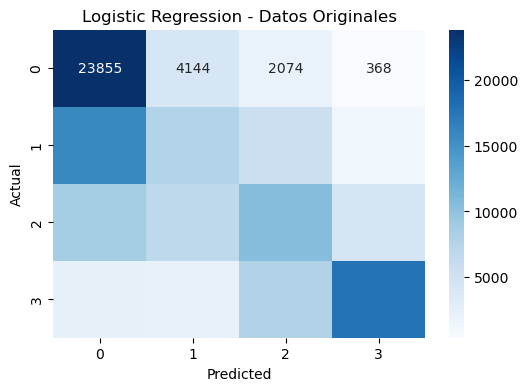


Matriz de Confusión (Datos Privatizados):


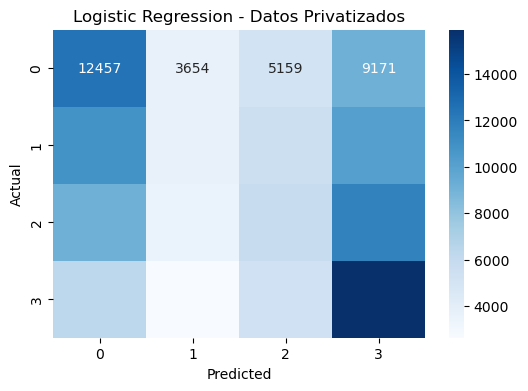


--- Resultados del Decision Tree ---

Datos Originales:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51     30441
           1       0.33      0.33      0.33     30275
           2       0.35      0.34      0.34     30340
           3       0.62      0.60      0.61     30262

    accuracy                           0.45    121318
   macro avg       0.45      0.45      0.45    121318
weighted avg       0.45      0.45      0.45    121318


Datos Privatizados:
              precision    recall  f1-score   support

           0       0.27      0.27      0.27     30441
           1       0.25      0.26      0.25     30275
           2       0.25      0.25      0.25     30340
           3       0.28      0.28      0.28     30262

    accuracy                           0.26    121318
   macro avg       0.26      0.26      0.26    121318
weighted avg       0.26      0.26      0.26    121318


Matriz de Confusión (Datos Originales):


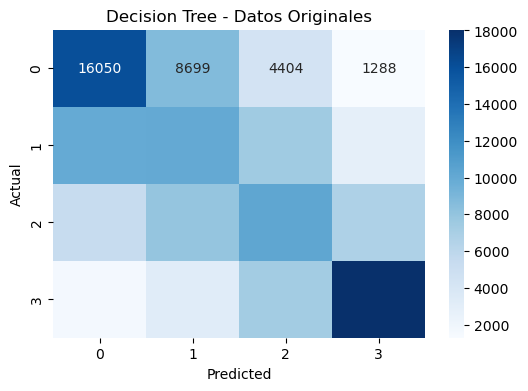


Matriz de Confusión (Datos Privatizados):


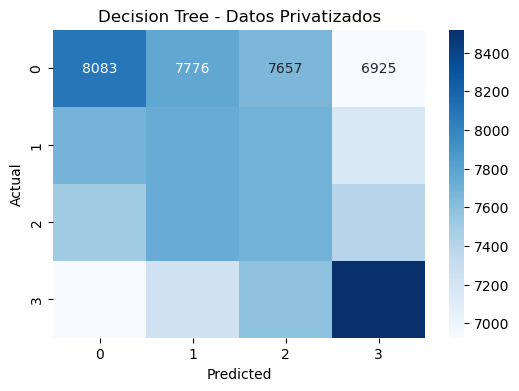


--- Resultados del Random Forest ---

Datos Originales:
              precision    recall  f1-score   support

           0       0.53      0.58      0.55     30441
           1       0.37      0.35      0.36     30275
           2       0.40      0.38      0.39     30340
           3       0.69      0.68      0.69     30262

    accuracy                           0.50    121318
   macro avg       0.50      0.50      0.50    121318
weighted avg       0.50      0.50      0.50    121318


Datos Privatizados:
              precision    recall  f1-score   support

           0       0.30      0.35      0.32     30441
           1       0.26      0.24      0.25     30275
           2       0.26      0.21      0.24     30340
           3       0.35      0.40      0.37     30262

    accuracy                           0.30    121318
   macro avg       0.29      0.30      0.29    121318
weighted avg       0.29      0.30      0.29    121318


Matriz de Confusión (Datos Originales):


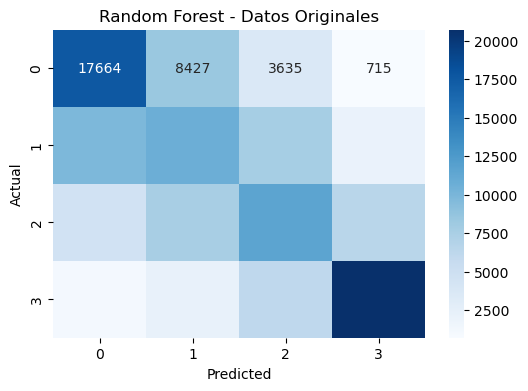


Matriz de Confusión (Datos Privatizados):


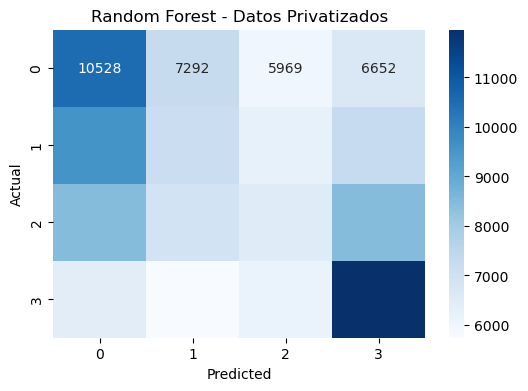


--- Resultados del XGBoost ---

Datos Originales:
              precision    recall  f1-score   support

           0       0.56      0.69      0.62     30441
           1       0.42      0.37      0.39     30275
           2       0.45      0.42      0.44     30340
           3       0.75      0.70      0.72     30262

    accuracy                           0.55    121318
   macro avg       0.54      0.55      0.54    121318
weighted avg       0.54      0.55      0.54    121318


Datos Privatizados:
              precision    recall  f1-score   support

           0       0.32      0.36      0.34     30441
           1       0.27      0.20      0.23     30275
           2       0.27      0.21      0.23     30340
           3       0.36      0.48      0.41     30262

    accuracy                           0.31    121318
   macro avg       0.30      0.31      0.30    121318
weighted avg       0.30      0.31      0.30    121318


Matriz de Confusión (Datos Originales):


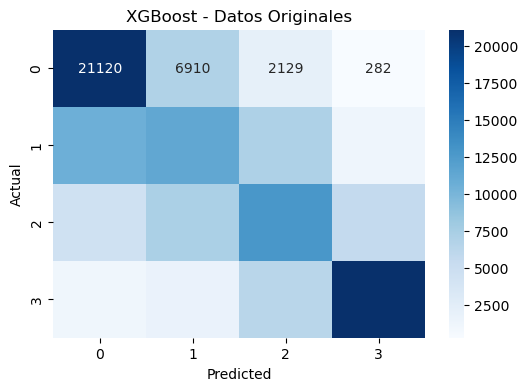


Matriz de Confusión (Datos Privatizados):


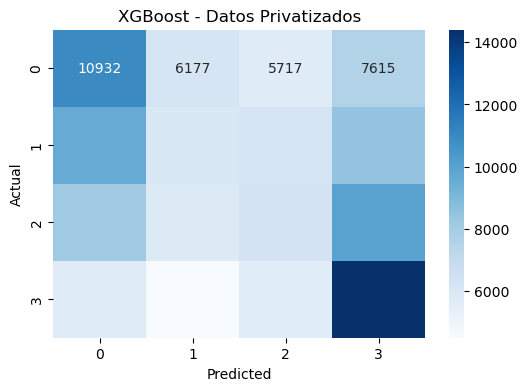

In [40]:


for model_name in comparison_results.keys():
    print(f"\n--- Resultados del {model_name} ---")
    
    print(f"\nDatos Originales:")
    print(comparison_results[model_name]['original']['classification_report'])
    
    print(f"\nDatos Privatizados:")
    print(comparison_results[model_name]['privatized']['classification_report'])
    
    print(f"\nMatriz de Confusión (Datos Originales):")
    plot_confusion_matrix(comparison_results[model_name]['original']['conf_matrix'], f'{model_name} - Datos Originales')
    
    print(f"\nMatriz de Confusión (Datos Privatizados):")
    plot_confusion_matrix(comparison_results[model_name]['privatized']['conf_matrix'], f'{model_name} - Datos Privatizados')



In [43]:
for model_name in comparison_results.keys():
    print(f"\n--- Resultados del {model_name} ---")
    
    print(f"\nDatos Originales:")
    print(comparison_results[model_name]['original']['classification_report'])
    
    print(f"\nDatos Privatizados:")
    print(comparison_results[model_name]['privatized']['classification_report'])
    
    print(f"\nMatriz de Confusión (Datos Originales):")
    print_confusion_matrix_as_text(
        comparison_results[model_name]['original']['conf_matrix'], 
        labels=['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3'],  # Labels for the four classes
        title=f'{model_name} - Datos Originales'
    )
    
    print(f"\nMatriz de Confusión (Datos Privatizados):")
    print_confusion_matrix_as_text(
        comparison_results[model_name]['privatized']['conf_matrix'], 
        labels=['Clase 0', 'Clase 1', 'Clase 2', 'Clase 3'],  # Labels for the four classes
        title=f'{model_name} - Datos Privatizados'
    )


--- Resultados del Logistic Regression ---

Datos Originales:
              precision    recall  f1-score   support

           0       0.47      0.78      0.59     30441
           1       0.37      0.25      0.30     30275
           2       0.41      0.35      0.37     30340
           3       0.74      0.59      0.66     30262

    accuracy                           0.49    121318
   macro avg       0.50      0.49      0.48    121318
weighted avg       0.50      0.49      0.48    121318


Datos Privatizados:
              precision    recall  f1-score   support

           0       0.32      0.41      0.36     30441
           1       0.27      0.12      0.17     30275
           2       0.27      0.19      0.22     30340
           3       0.34      0.53      0.41     30262

    accuracy                           0.31    121318
   macro avg       0.30      0.31      0.29    121318
weighted avg       0.30      0.31      0.29    121318


Matriz de Confusión (Datos Originales):

Logi

In [45]:
pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.3/459.3 kB 16.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
